In [5]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop


In [8]:
def read_image(filename, byteorder='>'):
    """
    Reads a PGM P5 (binary) image file and returns it as a NumPy array.
    """
    
    # first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()

    # --- SyntaxWarning (및 버그) 수정 ---
    
    # 1. (SyntaxWarning 수정)
    # 정규식 패턴에 rb"..." (raw byte string)를 사용합니다.
    # b"..."는 \d, \s 등을 이스케이프 문자로 해석하려 시도하며 경고를 유발합니다.
    # rb"..."는 백슬래시를 순수한 문자로 취급하여 정규식 엔진에 그대로 전달합니다.
    pattern = rb"(^P5\s(?:\s*#.*[\r\n])*" \
              rb"(\d+)\s(?:\s*#.*[\r\n])*" \
              rb"(\d+)\s(?:\s*#.*[\r\n])*" \
              rb"(\d+)\s(?:\s*#.*[\r\n]\s)*)"

    # 2. (BUG 수정)
    # re.search()가 실패하면 None을 반환하므로, .groups() 호출 시 에러가 발생합니다.
    # match 객체를 확인하고, 실패 시 예외를 발생시킵니다.
    match = re.search(pattern, buffer)
    
    if not match:
        raise ValueError(f"File '{filename}' is not a valid PGM P5 file or header is corrupted.")
        
    # 그룹(groups)을 추출합니다.
    header, width, height, maxval = match.groups()
    # ------------------------------------

    # 픽셀 데이터의 시작 위치(offset)를 계산합니다.
    # header는 헤더 전체 문자열을 담고 있습니다.
    offset = len(header)
    
    # 문자열로 추출된 값들을 정수로 변환합니다.
    width = int(width)
    height = int(height)
    maxval = int(maxval)

    # 픽셀 데이터 타입을 결정합니다.
    # maxval이 255 이하면 1바이트(u1), 초과면 2바이트(u2)입니다.
    dtype = 'u1' if maxval < 256 else byteorder + 'u2'
    
    # then we convert the image to numpy array using np.frombuffer
    return np.frombuffer(buffer,
                         dtype=dtype,
                         count=width * height,
                         offset=offset
                         ).reshape((height, width))

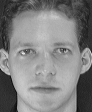

In [10]:
image_path = "./2/"
Image.open(image_path + "s1/1.pgm")


In [11]:
img = read_image(image_path + "s1/1.pgm")


In [12]:
img.shape


(112, 92)

In [13]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image(image_path+'s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image(image_path + 's' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image(image_path + 's' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')

            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
            img1 = read_image(image_path + 's' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image(image_path + 's' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [14]:
X, Y = get_data(size, total_sample_size)


In [15]:
print(X.shape)
print(Y.shape)

(20000, 2, 1, 56, 46)
(20000, 1)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)


In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

# 참고: 이 코드는 Keras 구버전(Theano 백엔드 기준) 스타일로 작성되었습니다.
# (예: Convolution2D, border_mode, dim_ordering)
# 최신 Keras/TensorFlow에서는 Conv2D, padding='valid', data_format='channels_first'를 사용합니다.
# -> Keras 3 API에 맞게 수정했습니다.

def build_base_network(input_shape):
    """
    Keras Sequential 모델을 사용하여 CNN 기반의
    '기초 네트워크(feature extractor)'를 구축하는 함수입니다.

    Args:
        input_shape (tuple): 모델이 입력받을 이미지의 형태.
                             'th' (Theano) 순서 기준 (채널, 높이, 너비).
                             예: (1, 100, 100)
    
    Returns:
        keras.models.Sequential: Keras Sequential 모델 객체
    """
    
    # Keras의 Sequential 모델을 생성합니다.
    # Sequential 모델은 레이어(층)를 순차적으로 쌓아 올리는 방식입니다.
    seq = Sequential()
    
    # 사용할 필터(filter)의 개수를 정의합니다.
    # 첫 번째 Conv 레이어는 6개, 두 번째는 12개의 필터를 사용합니다.
    nb_filter = [6, 12]
    # 컨볼루션 커널(kernel)의 크기를 3x3으로 정의합니다.
    kernel_size = 3
    
    
    # --- 첫 번째 컨볼루션 블록 (Conv -> ReLU -> Pool -> Dropout) ---
    
    # 1-1. 컨볼루션 레이어 1
    seq.add(Conv2D(nb_filter[0], # 필터 개수: 6
                   (kernel_size, kernel_size), # 커널 크기 (튜플로 전달)
                   input_shape=input_shape, # 첫 레이어의 입력 형태 지정
                   padding='valid',         # 'border_mode' -> 'padding'
                   data_format='channels_first')) # 'dim_ordering' -> 'data_format'
    
    # 1-2. 활성화 함수 (ReLU)
    seq.add(Activation('relu')) # 'relu' 활성화 함수로 비선형성 추가
    
    # 1-3. 맥스 풀링
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first')) # (2x2) 영역에서 가장 큰 값만 추출, 이미지 크기 감소
    
    # 1-4. 드롭아웃 (과적합 방지)
    seq.add(Dropout(.25)) # 학습 시 25%의 뉴런을 무작위로 비활성화
    
    # --- 두 번째 컨볼루션 블록 (Conv -> ReLU -> Pool -> Dropout) ---
    
    # 2-1. 컨볼루션 레이어 2
    seq.add(Conv2D(nb_filter[1], # 필터 개수: 12
                   (kernel_size, kernel_size), # 커널 크기 (튜플로 전달)
                   padding='valid', # 패딩 없음
                   data_format='channels_first')) # Theano 순서
    
    # 2-2. 활성화 함수 (ReLU)
    seq.add(Activation('relu'))
    
    # 2-3. 맥스 풀링
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first')) # (2x2) 맥스 풀링
    
    # 2-4. 드롭아웃
    seq.add(Dropout(.25)) # 25% 드롭아웃

    # --- 특징 벡터 추출을 위한 Dense 레이어 ---
    
    # 3-1. Flatten (1차원화)
    # 3D의 특징 맵(feature map)을 1D 벡터로 펼쳐서
    # Dense 레이어(완전 연결망)에 입력할 수 있도록 준비합니다.
    seq.add(Flatten())
    
    # 3-2. Dense (완전 연결) 은닉층
    seq.add(Dense(128, activation='relu')) # 128개 뉴런을 가진 은닉층
    
    # 3-3. 드롭아웃
    seq.add(Dropout(0.1)) # 10% 드롭아웃
    
    # 3-4. Dense (출력 레이어)
    # 이 50차원 벡터가 네트워크가 추출한 최종 '특징 벡터(feature vector)'가 됩니다.
    seq.add(Dense(50, activation='relu'))
    
    # 완성된 Sequential 모델을 반환합니다.
    return seq

In [21]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [22]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [26]:
base_network.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 6, 54, 44)      │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 6, 54, 44)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 27, 22)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 27, 22)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 25, 20)     │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 12, 25, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       184,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,618 (748.51 KB)

 Trainable params: 191,618 (748.51 KB)

 Non-trainable params: 0 (0.00 B)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])


epochs = 13
rms = RMSprop()

In [40]:
import keras.ops as ops  # Keras 3의 연산 모듈 import

def euclidean_distance(vects):
    """
    두 벡터(특징 벡터) 간의 유클리드 거리를 계산하는 함수입니다.
    Keras 3 API에 맞게 'keras.ops' (ops)를 사용합니다.
    """
    x, y = vects
    # K. -> ops. 로 모두 변경
    # 1. ops.square(x - y): 각 원소의 차이를 제곱 (element-wise)
    # 2. ops.sum(..., axis=1): 각 샘플(batch)별로 제곱의 합을 구함 (50차원 벡터 -> 1차원 스칼라)
    # 3. ops.sqrt(...): 제곱의 합에 루트를 씌워 유클리드 거리를 계산
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(sum_square)


def eucl_dist_output_shape(shapes):
    """
    Lambda 레이어의 출력 형태를 정의하는 헬퍼 함수입니다.
    """
    shape1, shape2 = shapes
    # (batch_size, 50) 두 개가 들어오면,
    # 거리 계산 후 (batch_size, 1) 형태의 출력이 나옵니다.
    return (shape1[0], 1)

# Lambda 레이어를 사용하여 두 특징 벡터 간의 거리를 계산합니다.
# 이 'distance'가 모델의 최종 출력이 됩니다.
distance = Lambda(euclidean_distance, 
                  output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

# 학습 에포크 및 옵티마이저 설정
epochs = 13
rms = RMSprop()

# Keras Model API를 사용하여 최종 샴 네트워크 모델을 정의합니다.
# === 오류 수정 ===
# 구버전: Model(input=[img_a, img_b], output=distance)
# 최신버전: Model(inputs=[...], outputs=...)로 수정했습니다.
model = Model(inputs=[img_a, img_b], outputs=distance)

In [41]:
def contrastive_loss(y_true, y_pred):
    """
    샴 네트워크(Siamese Network) 학습에 사용되는 Contrastive Loss 함수.
    Keras 3 API에 맞게 'keras.ops' (ops)를 사용합니다.
    
    y_true (Label):
      - 1: 두 이미지가 '같은' 쌍 (Positive pair)
      - 0: 두 이미지가 '다른' 쌍 (Negative pair)
      
    y_pred (Distance):
      - 모델이 예측한 두 이미지의 유클리드 거리
    """
    margin = 1
    
    # y_true를 float32로 캐스팅 (연산을 위해)
    y_true = ops.cast(y_true, 'float32')

    # K. -> ops. 로 모두 변경
    # 1. 같은 쌍 (y_true == 1)의 Loss: ops.square(y_pred)
    #    -> 거리가 가까워지도록(0에 가깝도록) 학습
    positive_loss = y_true * ops.square(y_pred)
    
    # 2. 다른 쌍 (y_true == 0)의 Loss: ops.square(ops.maximum(margin - y_pred, 0))
    #    -> 거리가 margin보다 멀어지도록 학습
    #    -> 단, 거리가 margin보다 이미 멀다면 Loss는 0
    negative_loss = (1 - y_true) * ops.square(ops.maximum(margin - y_pred, 0))
    
    # 두 Loss를 합산하여 평균을 반환
    return ops.mean(positive_loss + negative_loss)

# 옵티마이저 정의
rms = RMSprop()

# === 모델 컴파일 ===
# 수정된 contrastive_loss 함수를 사용하여 모델을 컴파일합니다.
model.compile(loss=contrastive_loss, optimizer=rms)

# 학습 데이터 준비
# x_train은 (샘플 수, 2, 채널, 높이, 너비) 형태라고 가정합니다.
# img_1 = 첫 번째 이미지 세트 (쌍의 왼쪽)
# img_2 = 두 번째 이미지 세트 (쌍의 오른쪽)
img_1 = x_train[:, 0]
img_2 = x_train[:, 1]

print("Starting model training...")

# === 모델 학습 ===
history = model.fit([img_1, img_2], y_train, validation_split=.25,
                    batch_size=128, verbose=2, epochs=epochs)

print("Model training finished.")

Starting model training...
Epoch 1/13
88/88 - 2s - 25ms/step - loss: 0.1894 - val_loss: 0.2205
Epoch 2/13
88/88 - 1s - 17ms/step - loss: 0.1201 - val_loss: 0.1844
Epoch 3/13
88/88 - 1s - 16ms/step - loss: 0.0928 - val_loss: 0.0978
Epoch 4/13
88/88 - 1s - 16ms/step - loss: 0.0766 - val_loss: 0.0980
Epoch 5/13
88/88 - 1s - 17ms/step - loss: 0.0677 - val_loss: 0.0729
Epoch 6/13
88/88 - 1s - 15ms/step - loss: 0.0588 - val_loss: 0.0511
Epoch 7/13
88/88 - 1s - 16ms/step - loss: 0.0549 - val_loss: 0.0433
Epoch 8/13
88/88 - 1s - 15ms/step - loss: 0.0511 - val_loss: 0.0420
Epoch 9/13
88/88 - 1s - 16ms/step - loss: 0.0470 - val_loss: 0.0365
Epoch 10/13
88/88 - 1s - 16ms/step - loss: 0.0438 - val_loss: 0.0326
Epoch 11/13
88/88 - 1s - 16ms/step - loss: 0.0417 - val_loss: 0.0309
Epoch 12/13
88/88 - 1s - 16ms/step - loss: 0.0399 - val_loss: 0.0319
Epoch 13/13
88/88 - 1s - 16ms/step - loss: 0.0379 - val_loss: 0.0257
Model training finished.


In [42]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [43]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [44]:
compute_accuracy(pred, y_test)


np.float64(0.945071482317532)